In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [4]:
##############################################
# 1. Diabetes Prediction Model (XGBoost & Logistic Regression Baseline)
##############################################

# Load the diabetes dataset
df_diabetes = pd.read_csv('/content/drive/MyDrive/diseases-datasets/diabetes.csv')

print("Diabetes Dataset Shape:", df_diabetes.shape)
print("\nDiabetes Dataset Info:")
print(df_diabetes.info())
print("\nDiabetes Dataset Summary:")
print(df_diabetes.describe())

# Convert columns to numeric
for col in df_diabetes.columns:
    df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce')

# Replace zeros with NaN in features where 0 is invalid
features_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in features_with_zeros:
    df_diabetes[feature] = df_diabetes[feature].replace(0, np.nan)

# Fill missing values with median
for feature in features_with_zeros:
    df_diabetes[feature] = df_diabetes[feature].fillna(df_diabetes[feature].median())

# Split into features and target
X_diabetes = df_diabetes.drop('Outcome', axis=1)
y_diabetes = df_diabetes['Outcome']

# Train-test split
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42)

# Standardize features
scaler_diab = StandardScaler()
X_train_diab_scaled = scaler_diab.fit_transform(X_train_diab)
X_test_diab_scaled = scaler_diab.transform(X_test_diab)

# ---- XGBoost Model ----
dtrain = xgb.DMatrix(X_train_diab_scaled, label=y_train_diab)
dtest = xgb.DMatrix(X_test_diab_scaled, label=y_test_diab)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1,
    'lambda': 1
}
num_rounds = 200
watchlist = [(dtrain, 'train'), (dtest, 'test')]
xgb_model = xgb.train(params, dtrain, num_rounds, evals=watchlist,
                      early_stopping_rounds=20, verbose_eval=50)

y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy_xgb = accuracy_score(y_test_diab, y_pred)
print(f"\n[Diabetes] XGBoost Accuracy: {accuracy_xgb:.4f}")
print("Classification Report for XGBoost:")
print(classification_report(y_test_diab, y_pred))

# Save XGBoost model and scaler
xgb_model.save_model('/content/drive/MyDrive/diseases-datasets/diabetes_model.json')
joblib.dump(scaler_diab, '/content/drive/MyDrive/diseases-datasets/diabetes_scaler.pkl')
print("Diabetes XGBoost model and scaler saved successfully!")

# ---- Baseline Model: Logistic Regression ----
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_diab_scaled, y_train_diab)
y_pred_lr = log_reg.predict(X_test_diab_scaled)
accuracy_lr = accuracy_score(y_test_diab, y_pred_lr)
print(f"\n[Diabetes] Logistic Regression (Baseline) Accuracy: {accuracy_lr:.4f}")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_diab, y_pred_lr))

Diabetes Dataset Shape: (768, 9)

Diabetes Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Diabetes Dataset Summary:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   

In [5]:
##############################################
# 2. Heart Disease Prediction Model (Decision Tree Baseline vs Random Forest)
##############################################
# Load heart disease dataset
df_heart = pd.read_csv('/content/drive/MyDrive/diseases-datasets/heart_disease_uci.csv')
try:
    heart_data = pd.read_csv('heart_disease_dataset.csv')
    print("Loaded full heart disease dataset from file")
except:
    heart_data = df_heart
    print("Using sample heart disease data for demonstration")

print(heart_data.head())

# Define numeric and categorical columns
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Convert boolean-like strings to boolean if needed
heart_data['fbs'] = heart_data['fbs'].map({'TRUE': True, 'FALSE': False})
heart_data['exang'] = heart_data['exang'].map({'TRUE': True, 'FALSE': False})

# Ensure numeric columns are numeric
for col in numeric_cols:
    heart_data[col] = pd.to_numeric(heart_data[col], errors='coerce')
heart_data['num'] = pd.to_numeric(heart_data['num'], errors='coerce')

# Define features and binary target (0 = no disease, 1 = disease)
X_heart = heart_data.drop(['id', 'dataset', 'num'], axis=1)
y_heart = (heart_data['num'] > 0).astype(int)

# Train-test split (using stratification)
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart, y_heart, test_size=0.2, random_state=42, stratify=y_heart)

# Preprocessing pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Create a ColumnTransformer for numeric columns only (categorical will be encoded separately)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='drop'
)

# Function to apply SMOTE after ensuring all features are numeric
def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

def create_pipeline(model):
    # This pipeline will be used only for numeric columns; categorical processing is done separately
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

results_heart = {}
for name, model in models.items():
    pipeline = create_pipeline(model)
    # Process numeric features
    X_train_num = preprocessor.fit_transform(X_train_heart[numeric_cols])
    # One-hot encode categorical features
    X_train_cat = pd.get_dummies(X_train_heart[categorical_cols], drop_first=True).reset_index(drop=True)
    # Combine numeric and categorical features
    X_train_combined = np.hstack((X_train_num, X_train_cat.values))

    # Apply SMOTE (all features numeric now)
    X_train_resampled, y_train_resampled = apply_smote(X_train_combined, y_train_heart)

    # Fit the classifier on resampled data
    pipeline.named_steps['classifier'].fit(X_train_resampled, y_train_resampled)

    # Process test data similarly
    X_test_num = preprocessor.transform(X_test_heart[numeric_cols])
    X_test_cat = pd.get_dummies(X_test_heart[categorical_cols], drop_first=True).reset_index(drop=True)
    # Make sure the test categorical DataFrame has the same columns as training
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)
    X_test_combined = np.hstack((X_test_num, X_test_cat.values))

    y_pred = pipeline.named_steps['classifier'].predict(X_test_combined)
    accuracy_model = accuracy_score(y_test_heart, y_pred)
    fpr, tpr, _ = roc_curve(y_test_heart, pipeline.named_steps['classifier'].predict_proba(X_test_combined)[:, 1])
    roc_auc = auc(fpr, tpr)

    results_heart[name] = {
        'accuracy': accuracy_model,
        'roc_auc': roc_auc,
        'classifier': pipeline.named_steps['classifier']
    }
    print(f"\n[Heart Disease] {name} Accuracy: {accuracy_model:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

# Choose best model based on accuracy (for demonstration)
best_model_name_heart = max(results_heart, key=lambda k: results_heart[k]['accuracy'])
print(f"\nBest Model from Tuned Pipelines: {best_model_name_heart}")

# ---- Baseline Model: Decision Tree ----
dt_pipeline = create_pipeline(DecisionTreeClassifier(random_state=42))
# Process training data
X_train_num = preprocessor.fit_transform(X_train_heart[numeric_cols])
X_train_cat = pd.get_dummies(X_train_heart[categorical_cols], drop_first=True).reset_index(drop=True)
X_train_combined = np.hstack((X_train_num, X_train_cat.values))
X_train_resampled, y_train_resampled = apply_smote(X_train_combined, y_train_heart)
dt_pipeline.named_steps['classifier'].fit(X_train_resampled, y_train_resampled)

# Process test data
X_test_num = preprocessor.transform(X_test_heart[numeric_cols])
X_test_cat = pd.get_dummies(X_test_heart[categorical_cols], drop_first=True).reset_index(drop=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)
X_test_combined = np.hstack((X_test_num, X_test_cat.values))
y_pred_dt = dt_pipeline.named_steps['classifier'].predict(X_test_combined)
accuracy_dt = accuracy_score(y_test_heart, y_pred_dt)
print(f"\n[Heart Disease] Decision Tree (Baseline) Accuracy: {accuracy_dt:.4f}")
print("Classification Report for Decision Tree:")
print(classification_report(y_test_heart, y_pred_dt))

# Save the best tuned heart disease model (here saving the best classifier from our results)
joblib.dump(results_heart[best_model_name_heart]['classifier'], '/content/drive/MyDrive/diseases-datasets/heart_disease_model.pkl')
print("Heart disease model saved successfully!")

Using sample heart disease data for demonstration
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2370 - loss: 567.6584 - mae: 21.0526 - mape: 81.8353 - val_accuracy: 1.0000 - val_loss: 165.9903 - val_mae: 9.8902 - val_mape: 43.1732
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9464 - loss: 145.8031 - mae: 9.3905 - mape: 42.4522 - val_accuracy: 1.0000 - val_loss: 99.2352 - val_mae: 8.0606 - val_mape: 37.9243
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9897 - loss: 105.5756 - mae: 8.2314 - mape: 38.6113 - val_accuracy: 1.0000 - val_loss: 85.6632 - val_mae: 7.5742 - val_mape: 36.6116
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 95.4246 - mae: 7.9133 - mape: 37.3756 - val_accuracy: 1.0000 - val_loss: 79.8419 - val_mae: 7.2787 - val_mape: 35.0151
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9962 - loss: 90.2360 - mae: 7.6901 - mape: 36.9791 - val_accuracy: 1.0000 - val_loss: 76.0727 - val_mae: 7.1483 - val_mape: 35.1288
Epoch

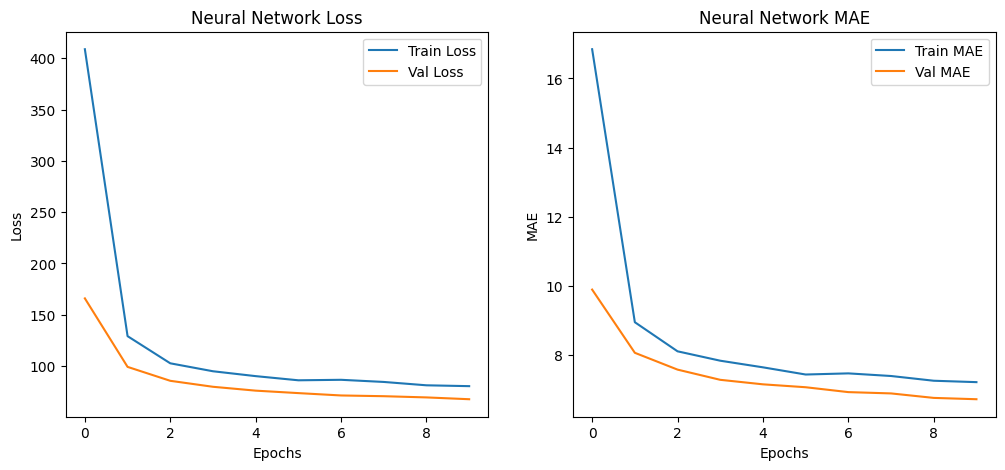

Parkinson's neural network model and scaler saved successfully!

[Parkinson's] Linear Regression (Baseline) MSE: 74.6605


In [6]:
##############################################
# 3. Parkinson's UPDRS Prediction Model (Neural Network & Linear Regression Baseline)
##############################################


# Load the Parkinson's dataset
df_parkinson = pd.read_csv('/content/drive/MyDrive/diseases-datasets/parkinsons_updrs.csv')

# Drop non-numeric columns and define features & targets
X_parkinson = df_parkinson.drop(columns=['subject#', 'motor_UPDRS', 'total_UPDRS'])
y_parkinson = df_parkinson[['motor_UPDRS', 'total_UPDRS']]

# Train-test split
X_train_par, X_test_par, y_train_par, y_test_par = train_test_split(
    X_parkinson, y_parkinson, test_size=0.2, random_state=42)

# Standardize features
scaler_par = StandardScaler()
X_train_par_scaled = scaler_par.fit_transform(X_train_par)
X_test_par_scaled = scaler_par.transform(X_test_par)

# ---- Neural Network Model ----
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_par_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2)  # Two outputs for regression
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape', 'accuracy'])
history = nn_model.fit(X_train_par_scaled, y_train_par, epochs=10, batch_size=32,
                       validation_data=(X_test_par_scaled, y_test_par))
eval_results = nn_model.evaluate(X_test_par_scaled, y_test_par)
print("\n[Parkinson's] Neural Network Evaluation (Loss, MAE, MAPE, Accuracy):", eval_results)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Neural Network Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Neural Network MAE')
plt.legend()
plt.show()

# Save the neural network model and scaler
nn_model.save('/content/drive/MyDrive/diseases-datasets/parkinsons_updrs_model.keras')
joblib.dump(scaler_par, '/content/drive/MyDrive/diseases-datasets/parkinsons_scaler.pkl')
print("Parkinson's neural network model and scaler saved successfully!")

# ---- Baseline Model: Multi-Output Linear Regression ----
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train_par_scaled, y_train_par)
y_pred_lin = lin_reg.predict(X_test_par_scaled)
mse_lin = mean_squared_error(y_test_par, y_pred_lin)
print(f"\n[Parkinson's] Linear Regression (Baseline) MSE: {mse_lin:.4f}")

In [7]:
##############################################
# Functions for Making Predictions
##############################################

# Diabetes Prediction Function (using saved XGBoost model)
def predict_diabetes(data, model_path='/content/drive/MyDrive/diseases-datasets/diabetes_model.json',
                     scaler_path='/content/drive/MyDrive/diseases-datasets/diabetes_scaler.pkl'):
    data_copy = data.copy()
    for feature in features_with_zeros:
        if feature in data_copy.columns:
            data_copy[feature] = data_copy[feature].replace(0, np.nan)
            median_values = {
                'Glucose': df_diabetes['Glucose'].median(),
                'BloodPressure': df_diabetes['BloodPressure'].median(),
                'SkinThickness': df_diabetes['SkinThickness'].median(),
                'Insulin': df_diabetes['Insulin'].median(),
                'BMI': df_diabetes['BMI'].median()
            }
            data_copy[feature] = data_copy[feature].fillna(median_values[feature])
    scaler = joblib.load(scaler_path)
    data_scaled = scaler.transform(data_copy)
    ddata = xgb.DMatrix(data_scaled)
    model = xgb.Booster()
    model.load_model(model_path)
    probabilities = model.predict(ddata)
    predictions = (probabilities > 0.5).astype(int)
    return predictions, probabilities

# Heart Disease Prediction Function (using saved model)
def predict_heart_disease(data, model_path='/content/drive/MyDrive/diseases-datasets/heart_disease_model.pkl'):
    # Assume data contains both numeric and categorical columns as in training
    # Process numeric and categorical features separately
    X_num = preprocessor.transform(data[numeric_cols])
    X_cat = pd.get_dummies(data[categorical_cols], drop_first=True).reset_index(drop=True)
    # Ensure same columns as training categorical data
    # For simplicity, we assume training used pd.get_dummies with drop_first=True
    # Here we reindex using training data columns (this may need to be adjusted)
    X_cat = X_cat.reindex(columns=pd.get_dummies(X_heart[categorical_cols], drop_first=True).columns, fill_value=0)
    X_combined = np.hstack((X_num, X_cat.values))
    model = joblib.load(model_path)
    prediction = model.predict(X_combined)[0]
    probability = model.predict_proba(X_combined)[0][1]
    return prediction, probability

# Parkinson's UPDRS Prediction Function (using saved neural network model)
def predict_parkinsons_updrs(data, model_path='/content/drive/MyDrive/diseases-datasets/parkinsons_updrs_model.keras',
                             scaler_path='/content/drive/MyDrive/diseases-datasets/parkinsons_scaler.pkl'):
    model = keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    data_scaled = scaler.transform(data)
    predictions = model.predict(data_scaled)
    motor_updrs = predictions[0][0]
    total_updrs = predictions[0][1]
    return motor_updrs, total_updrs

##############################################
# Example Predictions
##############################################

# Diabetes example prediction
print("\nExample Diabetes Prediction:")
new_diabetes_data = pd.DataFrame({
    'Pregnancies': [1],
    'Glucose': [85],
    'BloodPressure': [66],
    'SkinThickness': [29],
    'Insulin': [0],
    'BMI': [26.6],
    'DiabetesPedigreeFunction': [0.351],
    'Age': [31]
})
pred_diab, prob_diab = predict_diabetes(new_diabetes_data)
print(f"Diabetes Prediction: {'Diabetic' if pred_diab[0]==1 else 'Non-diabetic'}")
print(f"Probability: {prob_diab[0]:.4f}")

# Heart Disease example prediction
print("\nExample Heart Disease Prediction:")
# Use the first row of the test set for demonstration
sample_heart = X_test_heart.iloc[0:1]
pred_hd, prob_hd = predict_heart_disease(sample_heart)
print(f"Heart Disease Prediction: {'Heart Disease' if pred_hd==1 else 'No Heart Disease'}")
print(f"Probability: {prob_hd:.4f}")

# Parkinson's example prediction
print("\nExample Parkinson's UPDRS Prediction:")
sample_parkinson = X_test_par.iloc[0:1]
motor_updrs, total_updrs = predict_parkinsons_updrs(sample_parkinson)
print(f"Predicted Motor UPDRS: {motor_updrs:.2f}")
print(f"Predicted Total UPDRS: {total_updrs:.2f}")

print("\nAll model training and evaluation complete!")


Example Diabetes Prediction:
Diabetes Prediction: Non-diabetic
Probability: 0.0968

Example Heart Disease Prediction:
Heart Disease Prediction: No Heart Disease
Probability: 0.3400

Example Parkinson's UPDRS Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted Motor UPDRS: 14.90
Predicted Total UPDRS: 20.61

All model training and evaluation complete!
